In [2]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import h5py

#### Generate synthetic data

In [ ]:
np.random.seed(43)  # 
funcion = lambda x: 2*np.sin(0.5*x) + 3
x=np.linspace(0,20,100)
y_prueba=funcion(x)
y=funcion(x)+np.random.uniform(-0.2,0.2,len(x))
#y=funcion(x)
error_y=np.random.uniform(0.2,0.4,len(x))
datos = np.column_stack((x, y, error_y))

# Save the data to a text file
np.savetxt('datos.txt', datos, fmt='%.6f', header='x y error_y', comments='# ')

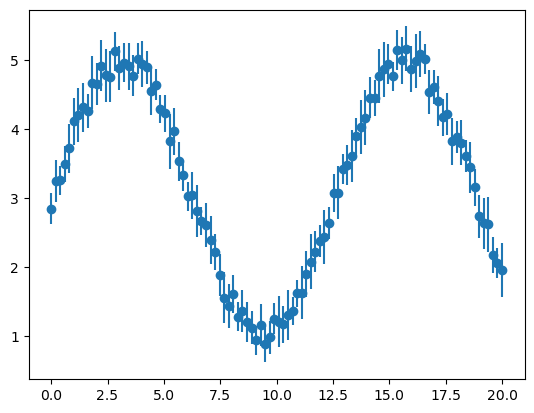

In [4]:
plt.figure()
#plt.plot(x,y,".")
plt.errorbar(x,y,yerr=error_y, fmt='o')
plt.show()

In [ ]:
# Define the log-likelihood and log-posterior functions (prior is uniform)
def log_likelihood(params, x, y, error_y):
    a, b = params
    model = a*np.sin(0.5*x)+b
    residuals = (y - model) / error_y
    return -0.5 * np.sum(residuals**2)
def log_posterior(params, x, y, error_y):
    a, b = params
    if -20 < a < 20  and -20 < b < 20:
        logpost = log_likelihood(params, x, y, error_y)
    else:
        logpost = -np.inf
    #print(logpost)
    return logpost

#### Sampling of the posterior probability distribution with Emcee

In [8]:
# set up the problem
ndim     = 2                                # number of parameters
nwalkers = 6                            # number of walkers
nwalkers=int(nwalkers)
ndim=int(ndim)
nsteps   = 9000                              # number of steps per walker
init0    = -18                          # initial value for a
init1    = 15                           # initial value for b


p0 = np.array([init0, init1])
# p0 will now be turned into a (nwalkers, ndim) array
p0 = p0 + np.zeros( (nwalkers, ndim) )
# Add a small random perturbation to each walker's initial position
# to avoid them all starting in the same place
p0[:,0] = p0[:,0] + np.random.uniform( low=-0.01, high=0.01, size=nwalkers )
p0[:,1] = p0[:,1] + np.random.uniform( low=-0.01, high=0.01, size=nwalkers )






# run the MCMC sampler
# here you should specify the output file in your personal computer directory
output_cadenas='/home/slandau/OneDrive/stats_peru/scripts/output_cadenas/'
# here the name of the output file is defined
backend   = emcee.backends.HDFBackend(output_cadenas+'prueba_2param_2.h5')
backend.reset(nwalkers, ndim)
# Define the step size of the MCMC sampler 
moves_list =  [emcee.moves.StretchMove(a=0.0001)]
# other moves, see emcee documentation 
#moves_list=[(emcee.moves.DEMove(), 0.4), (emcee.moves.DESnookerMove(), 0.3), (emcee.moves.StretchMove(a=2.0),0.8)]
#	        , (emcee.moves.KDEMove(), 0.3)]
#sampler = emcee.EnsembleSampler( nwalkers, ndim, log_posterior, args=(x_data, y_data, error_y),backend=backend,
#                                moves=moves_list)

sampler = emcee.EnsembleSampler( nwalkers, ndim, log_posterior, args=(x, y, error_y),backend=backend)






# maximum number of steps

max_n = nsteps

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)


# This will be useful to testing convergence
old_tau = np.inf


# Now we'll sample for up to max_n steps
for sample in sampler.sample(p0, iterations=max_n, progress=True):
    # Only check convergence every 100 steps
    if sampler.iteration % 100:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau

You must install the tqdm library to use progress indicators with emcee
